# Linear Regression Assignment
## Business Goal :
*Create a linear model from the given bike company data with `cnt` as the target variable using as many as predictor variables possible without hampering the accuracy of the model.*
It will be used by the management to understand how exactly the demands vary with different features. They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. Further, the model will be a good way for management to understand the demand dynamics of a new market. 
The company wants to know:

    Which variables are significant in predicting the demand for shared bikes.
    How well those variables describe the bike demands

We will follow the following steps to reach to our conclusion
 1. Reading, Understanding and Visualising the data.
 2. Preparing the data for modelling (dummy variables, re-scaling, train-test split, EDA etc.)
 3. Training the model recursively using RFE and manual TOP-DOWN approach.
 4. Residual Analysis to confirm the model follow Linear Regression Assumptions.
 5. Predictions and Evaluation on the test set.

In [1]:
# all imports and supress warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import r2_score

## Step 1: Reading, Understanding and Visualising the data

In [2]:
bikes = pd.read_csv('day.csv')

In [3]:
bikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [5]:
bikes.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


Inference on first view of data (including information from data dictionary)
- We have no null values so handling of nulls/imputation is not required
- Scale of some predictor variables is very different. We need MinMax scaling to bring them on same scale otherwise coefficients in resultant model will vary a lot making prediction difficult and confusing.
- Based on business domain knowledge, we can see that the target variable `cnt` is obtained by adding `casual` and `registered` so we have to drop both these columns otherwise the model will learn that these two variables are very significant for `cnt`.
- The column `dteday` can be dropped as we have already extracted information from it as `yr` and `month`
- We need to do some pre-processing for columns `season` by treating dummy variables (they carry the notion of some ordering like season 1 > season 2 but after season 4 we have cycle and again season 1 comes. So mathmatically it looks season 1 and 4 are far apart but they are not. Similar logic goes for `weekday and mnth`. 
- The following variables are categorical - `season, yr, mnth, weekday, holiday, workingday, weathersit`
- We can drop one out of temp and atemp as from the definiton it is clear that these two have a very high co-relation.
- We can also extract new column `DayOfMonth` from `dteday` before dropping it. Day of month can be significant for salaried people who tend to have less disposable income during last day of months. This is optional

## Dropping redundant columns
The reason we are dropping the columns before visualising is there is strong indication based on domain knowledge and also the pair plot will be a lot less complicated after removing 5 columns.

In [6]:
bikes = bikes.drop(['instant','dteday','temp', 'casual', 'registered'], axis=1)
bikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,11.46350,43.6957,12.522300,1600


In [7]:
bikes[['weathersit']].value_counts(subset = None, sort = True, ascending = False)
# weathersit stat has no value 4

weathersit
1             463
2             246
3              21
dtype: int64

## Visualizing the data

Let's draw some plots to see the relationship between variables.
We will draw pair plot which gives a scatterplot of each variable with respect to other. This will enable us to view relationship among the continious variables in pairs.

For categorical variables we will draw box plots to see their relationship with target variable.

<Figure size 2880x3240 with 0 Axes>

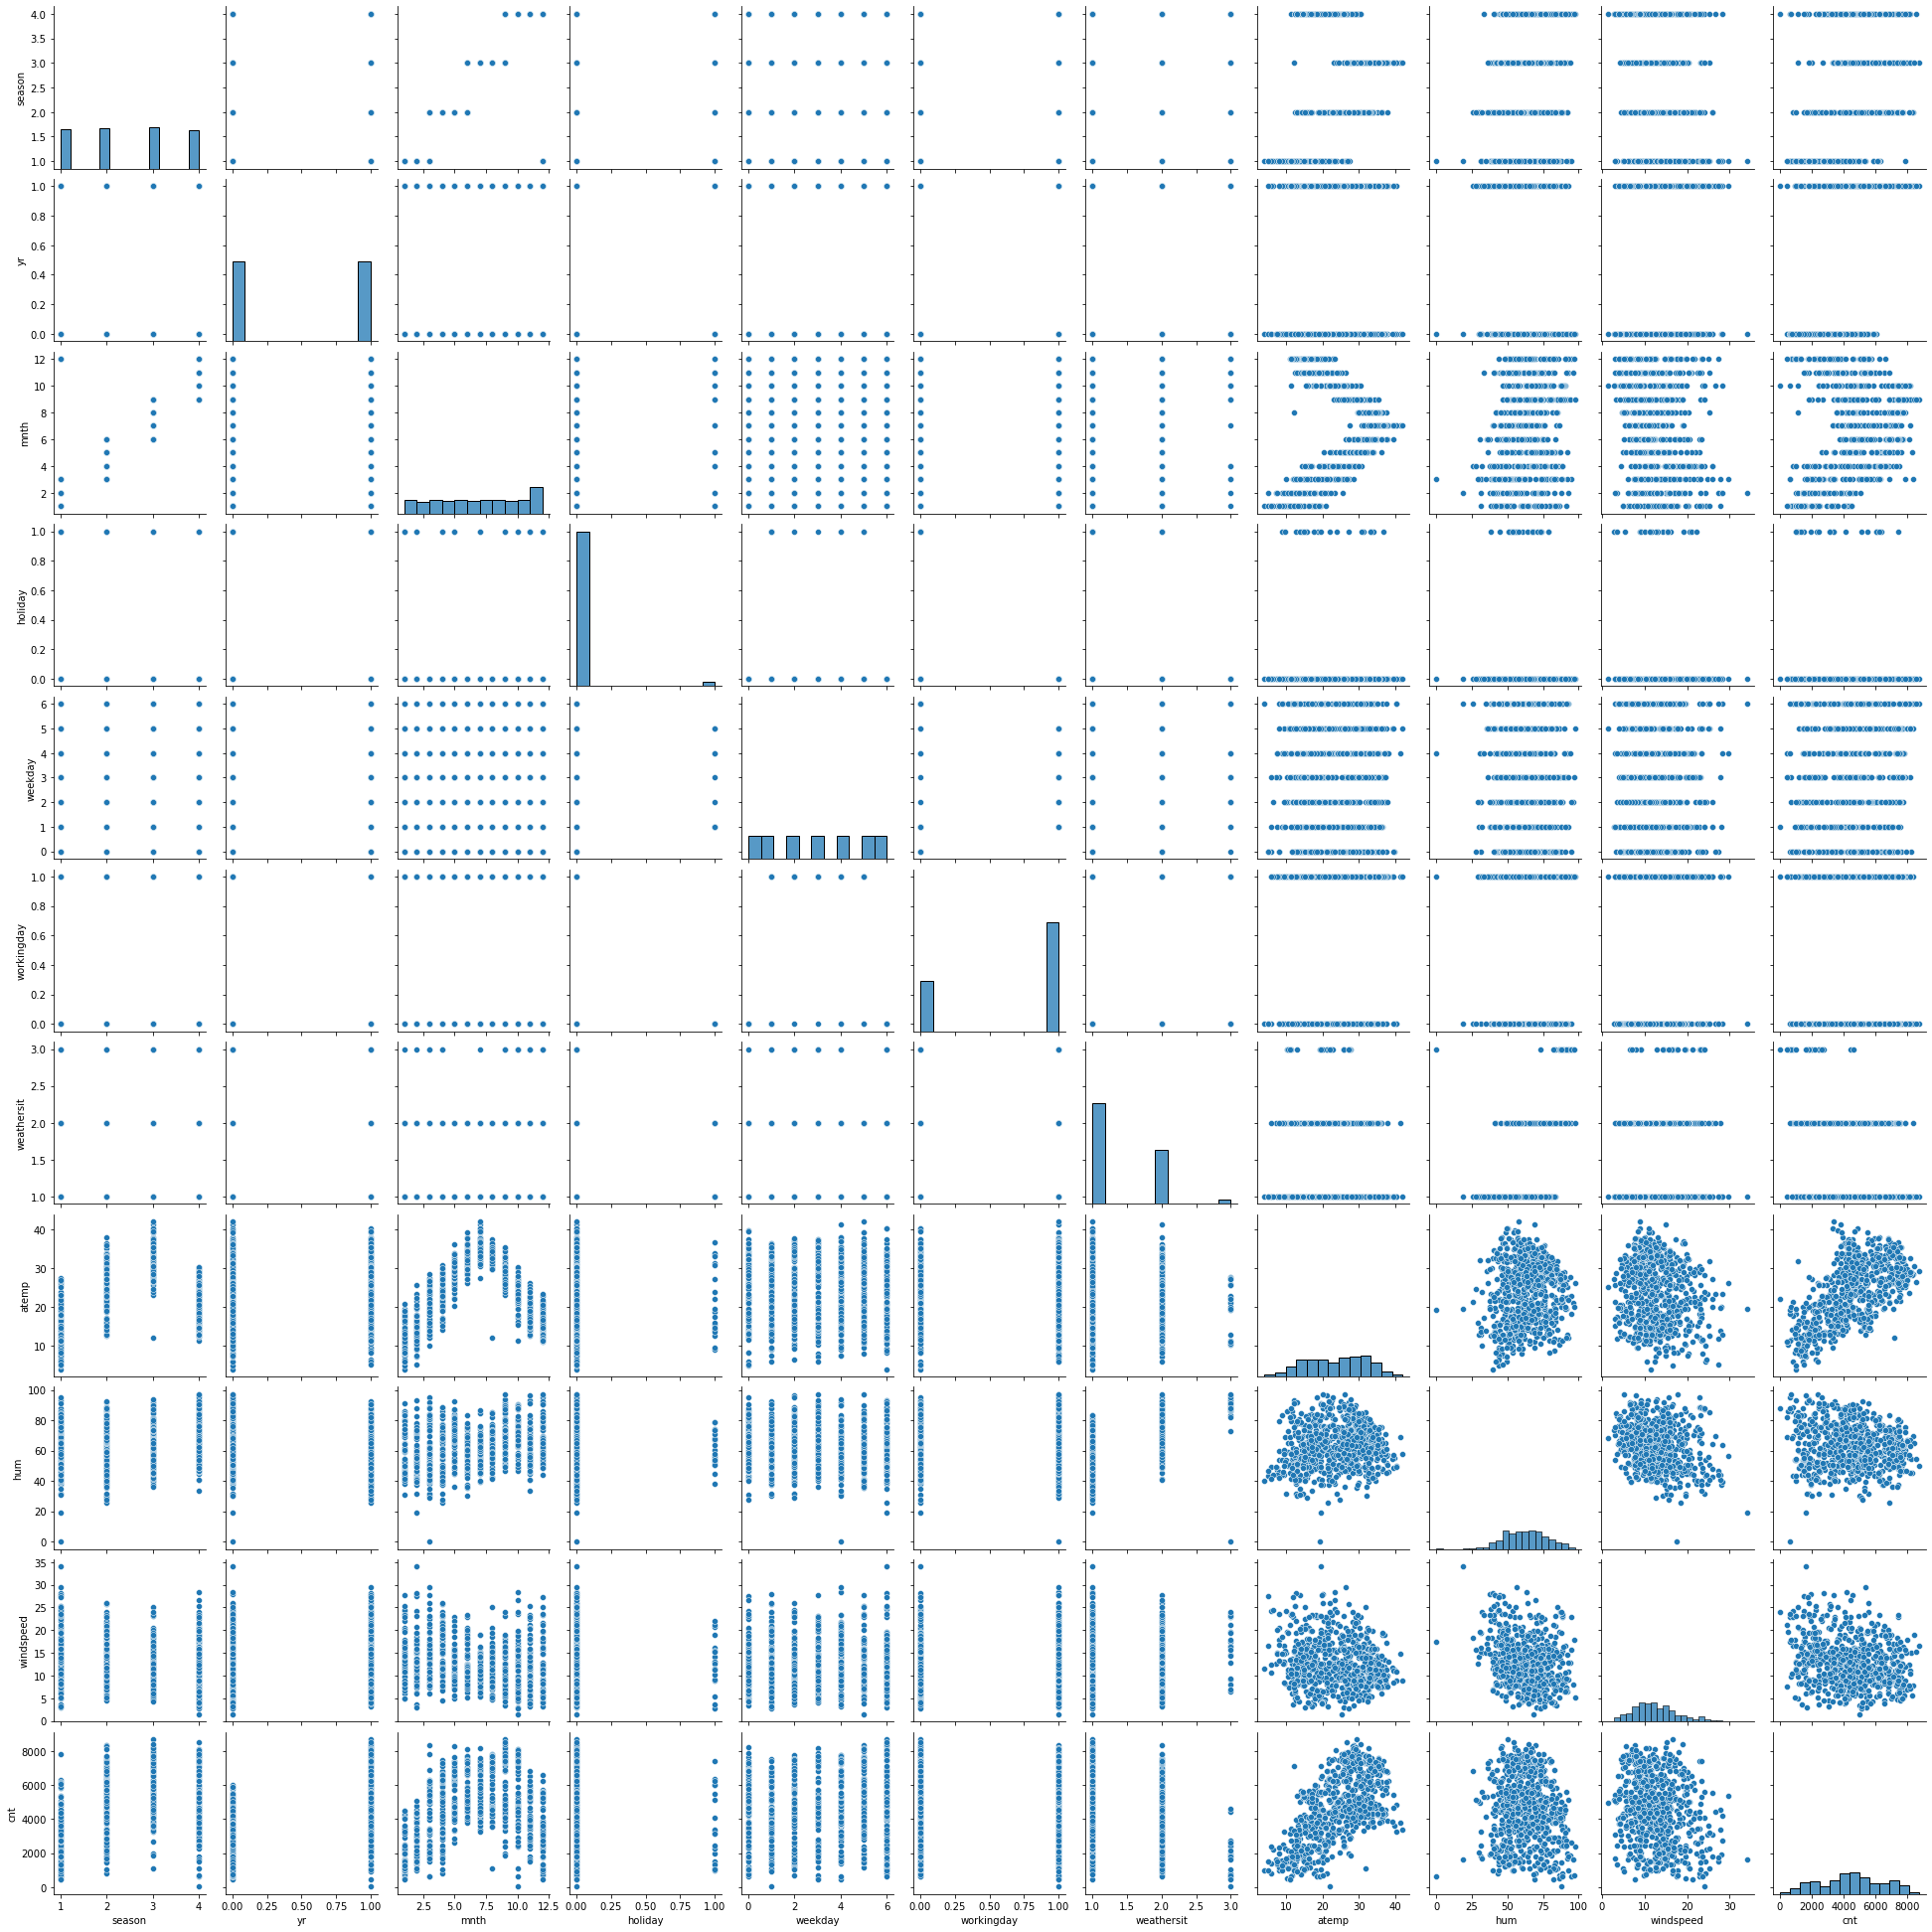

In [8]:
plt.figure(figsize = (40,45))
sns.pairplot(bikes)
plt.show()

#### Analysing the pair plot results 
This pair plot shows some interesting trends. Keeping target variable in focus (last column/row) We see significant linear trend between `cnt and atemp`. Our final model parameters should confirm this.
<br>
And when we trying to see relation among the continious variables, we don't see any alarming colinearity between them. For categorical variables we will use `box plots` to identify their colinearity with the continious target variable `cnt`.

#### Pairplot for numerical variables

<Figure size 1440x1800 with 0 Axes>

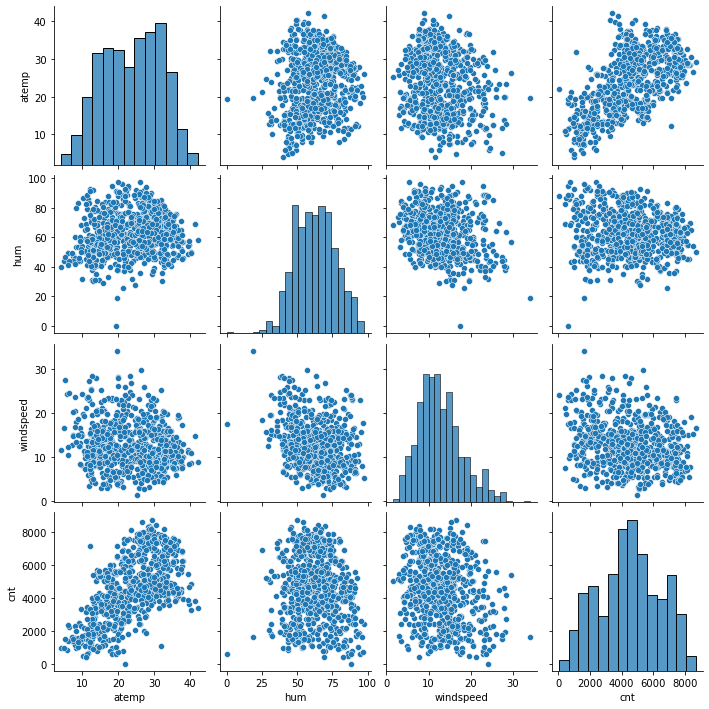

In [9]:
num_vars = ['atemp','hum', 'windspeed', 'cnt'] #this will also be used for scaling

plt.figure(figsize = (20,25))
sns.pairplot(bikes[num_vars])
plt.show()

#### Visualizing categorical variables
 Drawing box plots for all categorical variables vs the target variable.
 For `season, weathersit, mnth and weekday` we have to apply 1 hot encoding and create dummy variables.

<AxesSubplot:xlabel='season', ylabel='cnt'>

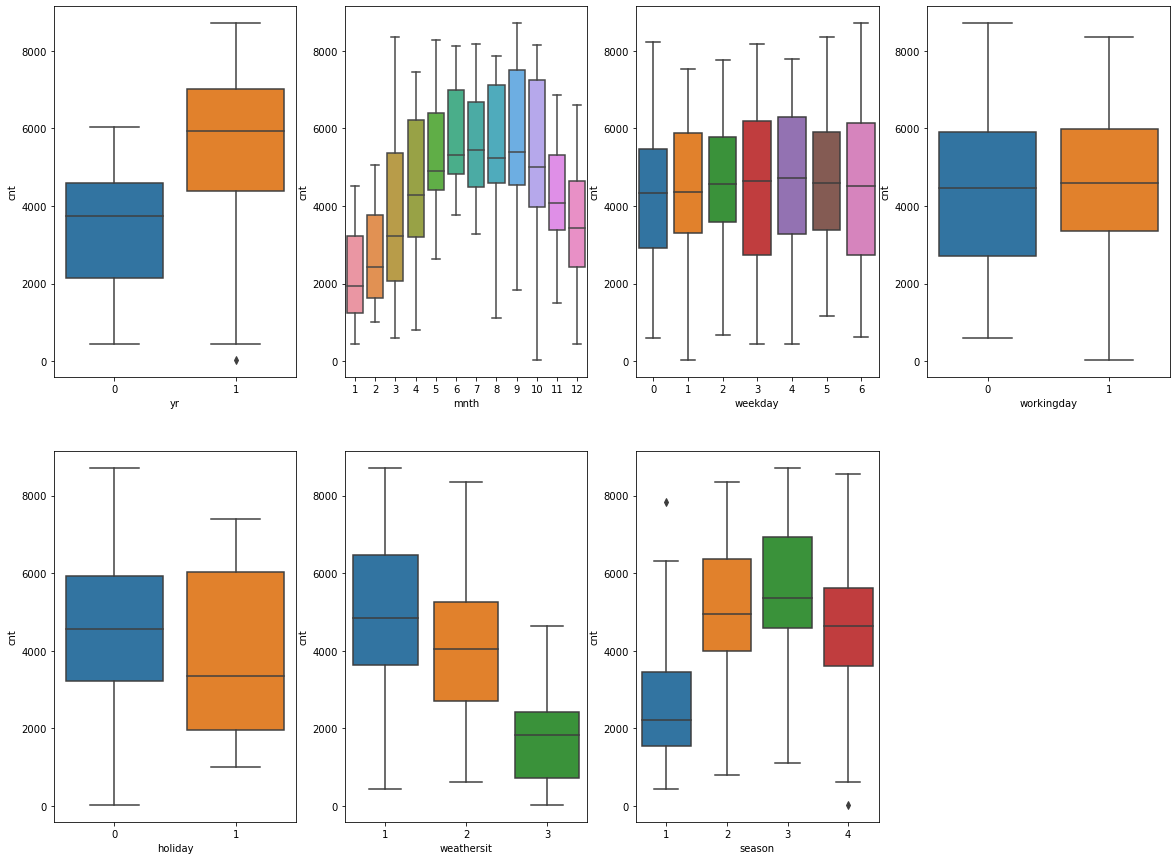

In [10]:
categ_vars = ['season', 'yr', 'mnth', 'weekday', 'holiday', 'workingday', 'weathersit']
plt.figure(figsize = (20,15))

plt.subplot(2,4,1)
sns.boxplot(x = 'yr', y = 'cnt', data = bikes)

plt.subplot(2,4,2)
sns.boxplot(x = 'mnth', y = 'cnt', data = bikes)

plt.subplot(2,4,3)
sns.boxplot(x = 'weekday', y = 'cnt', data = bikes)

plt.subplot(2,4,4)
sns.boxplot(x = 'workingday', y = 'cnt', data = bikes)

plt.subplot(2,4,5)
sns.boxplot(x = 'holiday', y = 'cnt', data = bikes)

plt.subplot(2,4,6)
sns.boxplot(x = 'weathersit', y = 'cnt', data = bikes)

plt.subplot(2,4,7)
sns.boxplot(x = 'season', y = 'cnt', data = bikes)

##### Above graphs show that there is some relation between our categorical variables and target variable. 
For `workingday` the relation looks weak but still we will use `workingday` in our model and later drop if it has a high p-value. 

## Step 2: Preparing the data for modelling

In [11]:
# create dummy variables for season and weathersit (as they are cyclic in nature)

# for mnth if we do 1 hot encoding it will create 11 columns. For weekday 6 columns.

def map_month(x):
    return x.map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})

def map_weekday(x):
    return x.map({0: "Sun", 1: "Mon", 2: "Tue", 3: "Wed", 4: "Thu", 5: "Fri", 6: "Sat" })

def map_season(x):
    return x.map({1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'})

def map_weathersit(x):
    return x.map({1: 'Clear', 2: 'Mist', 3: 'LightRain', 4: 'HeavyRain'})

#applying the function to the bike data set

bikes['season'] = bikes[['season']].apply(map_season)
bikes['weathersit'] = bikes[['weathersit']].apply(map_weathersit)
bikes['mnth'] = bikes[['mnth']].apply(map_month)
bikes['weekday'] = bikes[['weekday']].apply(map_weekday)

status = pd.get_dummies(bikes['season'], drop_first=True)
weath = pd.get_dummies(bikes['weathersit'], drop_first=True)
mnth = pd.get_dummies(bikes['mnth'], drop_first=True)
wkday = pd.get_dummies(bikes['weekday'], drop_first=True)

status = pd.concat([status, weath,mnth,wkday], axis = 1)
status.head()

,spring,summer,winter,LightRain,Mist,Aug,Dec,Feb,Jan,Jul,...,May,Nov,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed
0,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [12]:
# Add the results to the original bikes dataframe
bikes = pd.concat([bikes,status], axis = 1)
bikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,...,May,Nov,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed
0,spring,0,Jan,0,Sat,0,Mist,18.18125,80.5833,10.749882,...,0,0,0,0,0,1,0,0,0,0
1,spring,0,Jan,0,Sun,0,Mist,17.68695,69.6087,16.652113,...,0,0,0,0,0,0,1,0,0,0
2,spring,0,Jan,0,Mon,1,Clear,9.47025,43.7273,16.636703,...,0,0,0,0,1,0,0,0,0,0
3,spring,0,Jan,0,Tue,1,Clear,10.60610,59.0435,10.739832,...,0,0,0,0,0,0,0,0,1,0
4,spring,0,Jan,0,Wed,1,Clear,11.46350,43.6957,12.522300,...,0,0,0,0,0,0,0,0,0,1


In [13]:
# drop the existing season and weathersit column as we have extracted dummy variables
bikes = bikes.drop(['season','weathersit','mnth','weekday'], axis = 1)
bikes.head()

,yr,holiday,workingday,atemp,hum,windspeed,cnt,spring,summer,winter,...,May,Nov,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed
0,0,0,0,18.18125,80.5833,10.749882,985,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,17.68695,69.6087,16.652113,801,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,1,9.47025,43.7273,16.636703,1349,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,1,10.60610,59.0435,10.739832,1562,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,1,11.46350,43.6957,12.522300,1600,1,0,0,...,0,0,0,0,0,0,0,0,0,1


## Splitting the Data into Training and Testing Sets

In [14]:
df_train, df_test = train_test_split(bikes, train_size=0.7, random_state=100)
print(df_train.shape)
print(df_test.shape)

(510, 29)
(220, 29)


### Rescaling the Features 
We will use normalization for columns `atemp, hum, windspeed and cnt`

In [15]:
scaler = MinMaxScaler()
#create a list of numeric variables


df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.transform(df_test[num_vars])

df_train.head()

,yr,holiday,workingday,atemp,hum,windspeed,cnt,spring,summer,winter,...,May,Nov,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed
576,1,0,1,0.766351,0.725633,0.264686,0.827658,0,0,0,...,0,0,0,0,0,0,0,0,1,0
426,1,0,0,0.438975,0.640189,0.255342,0.465255,1,0,0,...,0,0,0,0,0,1,0,0,0,0
728,1,0,0,0.200348,0.498067,0.663106,0.204096,1,0,0,...,0,0,0,0,0,0,1,0,0,0
482,1,0,0,0.391735,0.504508,0.188475,0.482973,0,1,0,...,0,0,0,0,0,1,0,0,0,0
111,0,0,1,0.318819,0.751824,0.380981,0.191095,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# making sure the scaling worked fine on test set
df_test.describe()

,yr,holiday,workingday,atemp,hum,windspeed,cnt,spring,summer,winter,...,May,Nov,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.481818,0.036364,0.700000,0.532847,0.638221,0.313293,0.522154,0.254545,0.263636,0.236364,...,0.086364,0.072727,0.086364,0.086364,0.127273,0.118182,0.145455,0.163636,0.168182,0.100000
std,0.500809,0.187620,0.459303,0.217401,0.148694,0.159584,0.219163,0.436599,0.441609,0.425817,...,0.281541,0.260281,0.281541,0.281541,0.334038,0.323559,0.353363,0.370789,0.374881,0.300684
min,0.000000,0.000000,0.000000,0.025950,0.261915,-0.042808,0.048205,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.344870,0.529197,0.198843,0.378595,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.544652,0.625590,0.300126,0.524678,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.713308,0.743798,0.402718,0.677750,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,0.980934,1.002146,0.807474,0.963300,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Step 3 : Training the model

We have so many variables in the multi regression so there are several approaches to arrive at the final model

- `Top-Down` Start with all the variables and then remove one by one till optimal solution is reached
- `Bottom-Up` Start with one variable and keep on adding until adding a new does not add any more value to the model 
- We can also use automated ways like RFE (Recursive feature elimination) from python sklearn module

For this assignment we will use a combination of `Top-Down` and `RFE`.

In [17]:
# divide the training data frame into dependent and independent variables
y_train = df_train.pop('cnt')
X_train = df_train

In [18]:
#verify X_train should not have the target variable cnt
X_train.head()

,yr,holiday,workingday,atemp,hum,windspeed,spring,summer,winter,LightRain,...,May,Nov,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed
576,1,0,1,0.766351,0.725633,0.264686,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
426,1,0,0,0.438975,0.640189,0.255342,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
728,1,0,0,0.200348,0.498067,0.663106,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
482,1,0,0,0.391735,0.504508,0.188475,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
111,0,0,1,0.318819,0.751824,0.380981,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# We will use statsmodel with all 28 columns and view the p-values and r_score.
#build a model with all the variables
X_train_sm = sm.add_constant(X_train)

lr = sm.OLS(y_train, X_train_sm)

lr_model = lr.fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     101.4
Date:                Wed, 11 May 2022   Prob (F-statistic):          1.07e-179
Time:                        07:38:32   Log-Likelihood:                 523.21
No. Observations:                 510   AIC:                            -990.4
Df Residuals:                     482   BIC:                            -871.9
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2594      0.035      7.397      0.000       0.190       0.328
yr             0.2344      0.008     28.934      0.000       0.218       0.250
holiday        0.0212      0.024      0.882      0.378      -0.026       0.068
workingday     0.1004      0.012      8.176      0.000       0.076       0.124
atemp          0.4160      0.045      9.174      0.000       0.327       0.505
hum           -0.1459      0.039     -3.761      0.000      -0.222      -0.070
windspeed     -0.1683      0.026     -6.488      0.000      -0.219      -0.117
spring        -0.0519      0.030     -1.724      0.085      -0.111       0.007
summer         0.0348      0.026      1.327      0.185      -0.017       0.086
winter         0.1015      0.028      3.612      0.000       0.046       0.157
LightRain     -0.2530      0.027     -9.497      0.000      -0.305      -0.201
Mist          -0.0612      0.010     -5.830      0.000      -0.082      -0.041
Aug            0.0419      0.033      1.257      0.209      -0.024       0.107
Dec           -0.0526      0.034     -1.560      0.120      -0.119       0.014
Feb           -0.0404      0.033     -1.221      0.223      -0.105       0.025
Jan           -0.0736      0.034     -2.188      0.029      -0.140      -0.007
Jul           -0.0147      0.035     -0.424      0.672      -0.083       0.053
Jun            0.0242      0.024      1.000      0.318      -0.023       0.072
Mar           -0.0003      0.025     -0.014      0.989      -0.049       0.048
May            0.0363      0.021      1.734      0.084      -0.005       0.077
Nov           -0.0457      0.037     -1.249      0.212      -0.118       0.026
Oct            0.0076      0.036      0.210      0.833      -0.063       0.079
Sep            0.0957      0.032      2.984      0.003       0.033       0.159
Mon           -0.0263      0.015     -1.702      0.089      -0.057       0.004
Sat            0.0961      0.014      6.934      0.000       0.069       0.123
Sun            0.0417      0.014      2.964      0.003       0.014       0.069
Thu           -0.0131      0.016     -0.835      0.404      -0.044       0.018
Tue           -0.0214      0.016     -1.368      0.172      -0.052       0.009
Wed           -0.0082      0.015     -0.545      0.586      -0.038       0.021
==============================================================================
Omnibus:                       85.560   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              258.432
Skew:                          -0.787   Prob(JB):                     7.63e-57
Kurtosis:                       6.112   Cond. No.                     1.49e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is co

##### Inferences from first model
- p-value of many variables such as `Mar` is very high which makes these variables insignificant.
- adjusted R2 is 84.6 % which is really good but we have to drop several columns and calculate it again.
- We need to calculate VIF and then decide is there any other column apart from `Mar` which needs to be dropped first. But doing this way is tedious so we will use RFE to select top ten variables and then apply VIF logic.
- As expected from the scatterplot, `atemp` has the highest coefficient (but we might have to drop it based on p-value or VIF)


### Checking VIF

Variance Inflation Factor or VIF, gives a basic quantitative idea about how much the feature variables are correlated with each other. It is an extremely important parameter to test our linear model. VIF will also confirm one of the assumtions of linear regression `No or little Multicollinearity`. The formula for calculating `VIF` is:

### $ VIF_i = \frac{1}{1 - {R_i}^2} $

In [20]:
# create a dataframe that will contain the names of all feature variables and their respective VIFs
vif = pd.DataFrame()

vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range (X_train.shape[1])]
vif['VIF'] = round( vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
2,workingday,83.16
23,Sat,19.32
24,Sun,17.99
6,spring,10.70
8,winter,9.41
7,summer,8.20
19,Nov,6.76
20,Oct,6.47
11,Aug,6.18
3,atemp,5.93


#####  Looks like  we have to drop 15+ columns. If we do manually we should drop them one by one and recalculate VIF which is tedious. Other option is to use RFE so that Python will automatically select best n variables.
Since number of columns is high we are going to use RFE to get top 10 variables and refine the model manually.

In [21]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression(normalize=True)
lm.fit(X_train, y_train)

rfe = RFE(lm, 10)
rfe = rfe.fit(X_train, y_train)

In [22]:
list(zip(X_train.columns, rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 14),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', False, 8),
 ('summer', True, 1),
 ('winter', True, 1),
 ('LightRain', True, 1),
 ('Mist', False, 2),
 ('Aug', True, 1),
 ('Dec', False, 6),
 ('Feb', False, 5),
 ('Jan', False, 4),
 ('Jul', False, 12),
 ('Jun', False, 10),
 ('Mar', False, 19),
 ('May', False, 9),
 ('Nov', False, 7),
 ('Oct', False, 18),
 ('Sep', True, 1),
 ('Mon', False, 11),
 ('Sat', False, 13),
 ('Sun', False, 3),
 ('Thu', False, 16),
 ('Tue', False, 15),
 ('Wed', False, 17)]

In [23]:
# printing the predictor variables selected by RFE
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'atemp', 'hum', 'windspeed', 'summer', 'winter',
       'LightRain', 'Aug', 'Sep'],
      dtype='object')

In [24]:
# we will use the columns selected by RFE and build our models using statsmodel to see the summary and finetune the model

X = X_train[col]

X_train_sm = sm.add_constant(X)

lr = sm.OLS(y_train, X_train_sm)

lr_model = lr.fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     240.0
Date:                Wed, 11 May 2022   Prob (F-statistic):          1.71e-183
Time:                        07:45:56   Log-Likelihood:                 487.60
No. Observations:                 510   AIC:                            -953.2
Df Residuals:                     499   BIC:                            -906.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2740      0.027     10.311      0.000       0.222       0.326
yr             0.2272      0.008     26.958      0.000       0.211       0.244
holiday       -0.0856      0.027     -3.219      0.001      -0.138      -0.033
atemp          0.5900      0.023     25.160      0.000       0.544       0.636
hum           -0.2901      0.032     -9.051      0.000      -0.353      -0.227
windspeed     -0.1824      0.027     -6.871      0.000      -0.235      -0.130
summer         0.0985      0.011      8.694      0.000       0.076       0.121
winter         0.1446      0.011     13.101      0.000       0.123       0.166
LightRain     -0.1836      0.026     -7.077      0.000      -0.235      -0.133
Aug            0.0642      0.017      3.838      0.000       0.031       0.097
Sep            0.1238      0.017      7.367      0.000       0.091       0.157
==============================================================================
Omnibus:                       52.532   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.235
Skew:                          -0.561   Prob(JB):                     1.28e-26
Kurtosis:                       5.086   Cond. No.                         15.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
# recalculate VIF
# create a dataframe that will contain the names of all feature variables and their respective VIFs
vif = pd.DataFrame()

vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range (X.shape[1])]
vif['VIF'] = round( vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
3,hum,10.27
2,atemp,8.56
4,windspeed,3.56
0,yr,2.01
5,summer,1.83
6,winter,1.73
8,Aug,1.54
9,Sep,1.30
7,LightRain,1.09
1,holiday,1.04


We see that the model suggested by RFE has picked `hum` and `atemp` having a very high VIF. However, p-value of all the variables is almost 0 meaning all variables are significant

We will drop `hum` first and see the effect on VIF of remaining variables.
 
 

In [26]:
#dropping hum and rebuild the model

X = X.drop('hum', axis=1)

X_train_sm = sm.add_constant(X)

lr = sm.OLS(y_train, X_train_sm)

lr_model = lr.fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     221.7
Date:                Wed, 11 May 2022   Prob (F-statistic):          2.87e-168
Time:                        07:46:33   Log-Likelihood:                 448.84
No. Observations:                 510   AIC:                            -877.7
Df Residuals:                     500   BIC:                            -835.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0862      0.018      4.817      0.000       0.051       0.121
yr             0.2342      0.009     25.882      0.000       0.216       0.252
holiday       -0.0813      0.029     -2.835      0.005      -0.138      -0.025
atemp          0.5674      0.025     22.576      0.000       0.518       0.617
windspeed     -0.1239      0.028     -4.463      0.000      -0.178      -0.069
summer         0.0880      0.012      7.245      0.000       0.064       0.112
winter         0.1252      0.012     10.729      0.000       0.102       0.148
LightRain     -0.2454      0.027     -9.096      0.000      -0.298      -0.192
Aug            0.0538      0.018      2.993      0.003       0.018       0.089
Sep            0.1048      0.018      5.834      0.000       0.070       0.140
==============================================================================
Omnibus:                       58.134   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.823
Skew:                          -0.665   Prob(JB):                     1.17e-25
Kurtosis:                       4.907   Cond. No.                         10.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
# recalculate VIF
# create a dataframe that will contain the names of all feature variables and their respective VIFs
vif = pd.DataFrame()

vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range (X.shape[1])]
vif['VIF'] = round( vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
2,atemp,4.90
3,windspeed,2.96
0,yr,2.00
4,summer,1.80
7,Aug,1.54
5,winter,1.46
8,Sep,1.29
6,LightRain,1.06
1,holiday,1.04


Now we see that `atemp` has a high VIF. We will keep it as during EDA we saw it was showing positive corelation with `cnt` and VIF is just under 5. However, it can be dropped on user's discretion.

#### Based on the VIF and P values we can say that we have arrived at our final model where we can't eliminate any more variables
In total we have 9 independent variables in our model predicting the dependent variable explaining 79.6% variance in `cnt` with `atemp` as most significant contributer. 

## Step 4: Residual Analysis of the train data

So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [28]:
y_train_pred = lr_model.predict(X_train_sm)

<AxesSubplot:ylabel='Density'>

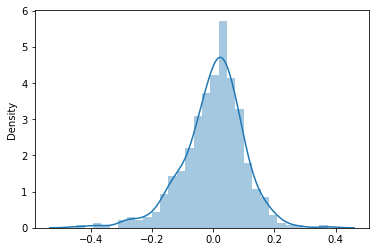

In [29]:
res = y_train - y_train_pred
sns.distplot(res)

## Step 5: Evaluation and Making Predictions Using the Final Model

Now that we have fitted the model and checked the normality of error terms, it's time to go ahead and make predictions using the final model.

##### we have to do the same scaling on test set as we did on train set otherwise we get invalid results

In [30]:
# Evaluate the model on the test data set
y_test = df_test.pop('cnt')
X_test = df_test

In [31]:
# We have to remove the columns from the test set as well (which we removed from train set after split during the model creation)
# We can just pick the columns in final model
X_test_sm = X_test[col]
X_test_sm = X_test_sm.drop('hum', axis=1) #we dropped hum which was picked by RFE 
X_test_sm = sm.add_constant(X_test_sm)
X_test_sm

,const,yr,holiday,atemp,windspeed,summer,winter,LightRain,Aug,Sep
184,1.0,0,1,0.769660,0.084219,0,0,0,0,0
535,1.0,1,0,0.842587,0.153728,1,0,0,0,0
299,1.0,0,0,0.496145,0.334206,0,1,0,0,0
221,1.0,0,0,0.795343,0.339570,0,0,0,1,0
152,1.0,0,0,0.741471,0.537414,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
702,1.0,1,0,0.511907,0.283397,0,1,0,0,0
127,1.0,0,0,0.577380,0.069510,1,0,0,0,0
640,1.0,1,0,0.682653,0.052115,0,1,0,0,0
72,1.0,0,0,0.332005,0.203418,0,0,0,0,0


In [32]:
# predict
y_test_pred = lr_model.predict(X_test_sm)

Text(0, 0.5, 'y_train_pred')

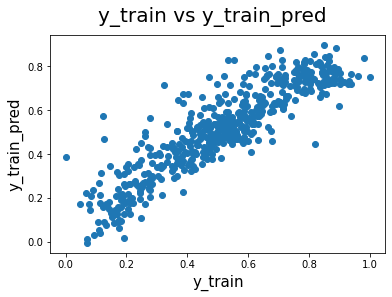

In [33]:
# Plotting y_train and y_train_pred to understand see spread on training data
fig = plt.figure()
plt.scatter(y_train, y_train_pred)
fig.suptitle('y_train vs y_train_pred', fontsize=20)
plt.xlabel('y_train', fontsize=15)
plt.ylabel('y_train_pred', fontsize=15)

Text(0, 0.5, 'y_test_pred')

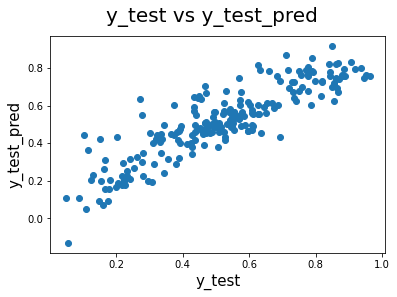

In [34]:
# Plotting y_test and y_test_pred to understand the spread
fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_test_pred', fontsize=20)
plt.xlabel('y_test', fontsize=15)
plt.ylabel('y_test_pred', fontsize=15)

##### Linear Regression Assumption - Homoscedasticity
We will make a scatterplot with the residuals against the dependent variable. The error terms must be constant, it means errors should not increase/decrese with the value of target variable.

Text(0, 0.5, 'errors')

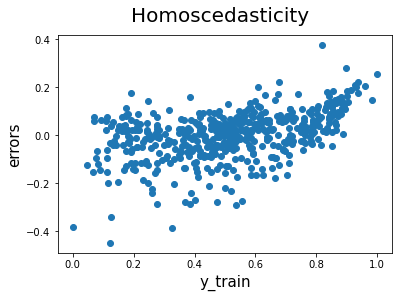

In [35]:
# Plotting y_test and residuals to verify error terms are constant
fig = plt.figure()
plt.scatter(y_train, res)
fig.suptitle('Homoscedasticity', fontsize=20)
plt.xlabel('y_train', fontsize=15)
plt.ylabel('errors', fontsize=15)

### Linear Regression Assumption - All independent variables are uncorrelated with the error term

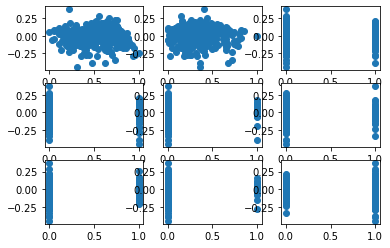

In [36]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3)
ax1.scatter(X_train_sm['atemp'], res)
ax2.scatter(X_train_sm['windspeed'], res)
ax3.scatter(X_train_sm['summer'], res)
ax4.scatter(X_train_sm['winter'], res)
ax5.scatter(X_train_sm['LightRain'], res)
ax6.scatter(X_train_sm['Aug'], res)
ax7.scatter(X_train_sm['Sep'], res)
ax8.scatter(X_train_sm['holiday'], res)
ax9.scatter(X_train_sm['yr'], res)
plt.show()

### Final Model Evaluation - Calculate the r_score on test set (data unseen by model)

In [37]:
#evaluate the r2 score on test set
r2_score(y_true = y_test, y_pred = y_test_pred)

0.7744211243610739

##### We see that r2 on test data is very close to what we got on training data. The model had never seen the test data and it means that our model would be good in predicting target variable on future values of the 9 attributes in model. The model also follows the main assumptions of linear regressio and has a very good accuracy on test set.
